# Abstract: 
> Topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents.<br /> 
Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body.
Cleaning text documents and initial analysis.
#### Inthis notebook I am cleaning the text data using following steps:
- Removing Duplicate records
- Droping columns which may not be usful in analysis
- Text Cleaning:
    - Contraction Mapping
    - Removing web tags, punctuations, special charecters (regex)
    - Tokenization
    - Removing Stopwords
    - Lemmatization
- Visualization

# Importing Libraries:

In [1]:
# Data Manupulation
import pandas as pd
import numpy as np
import itertools  

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text cleaning
import re
import math
from bs4 import BeautifulSoup
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from nltk.corpus import wordnet
import spacy

# setting colwidth to 200; help in the visual analysis of sentences 
pd.set_option("display.max_colwidth", 200)
%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
df_text = pd.read_csv('data.csv')

In [3]:
df_text.head(3)

,Unnamed: 0,description
0,96100,"DUBAI (Reuters) - The group led by al Qaeda ally Abu Musab al-Zarqawi said it beheaded two Iraqi soldiers in broad daylight in Mosul, a statement found on an Islamist Web site on Friday said."
1,116223,"SANTA MONICA, Calif. (Reuters) - The stars of the video game industry came out in force on Tuesday night to honor their peers for creative excellence -- taking a page from the Hollywood playbo..."
2,17386,"AP - A week of rallies, marches and nearly 1,800 arrests left anti-Bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody."


In [4]:
# df_text.rename(columns = {'Unnamed: 0':'news_id'}, inplace = True)
df_text.drop(columns = ['Unnamed: 0'], inplace = True)
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [5]:
df_text.head(3)

,description
0,"DUBAI (Reuters) - The group led by al Qaeda ally Abu Musab al-Zarqawi said it beheaded two Iraqi soldiers in broad daylight in Mosul, a statement found on an Islamist Web site on Friday said."
1,"SANTA MONICA, Calif. (Reuters) - The stars of the video game industry came out in force on Tuesday night to honor their peers for creative excellence -- taking a page from the Hollywood playbo..."
2,"AP - A week of rallies, marches and nearly 1,800 arrests left anti-Bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody."


# Text Cleaning

### Dropping duplicates records and null rows:

In [6]:
if df_text.duplicated(subset=['description']).any():
    print('duplicated records found:\n', df_text[df_text.duplicated(subset=['description'])])
    
    df_text.drop_duplicates(subset = ['description'], inplace=True)
    df_text.dropna(subset = ['description'], axis=0, inplace=True)
    df_text.reset_index()

duplicated records found:
                                                                                                                                                                                                   description
3628  AP - Apple Computer Inc. stock jumped to a four-year high Monday after a major Wall Street firm nearly doubled its price target on the stock, saying that customer satisfaction with its iPod music ...
4026                                                                 Software maker heads to LA to show off a host of gadgets that use one or another Microsoft technology to access movies, music and video.
4069   CHICAGO (Reuters) - Wal-Mart Stores Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=WMT.N target=/stocks/quickinfo/fullquote"&gt;WMT.N&lt;/A&gt;, the  world's largest retai...
4683  More than a year after the German city of Munich declared its landmark intention to abandon Microsoft Windows in favor of upstart rival Linux, 

In [7]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9993 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  9993 non-null   object
dtypes: object(1)
memory usage: 156.1+ KB


### Expanding the contractions
> Performing basic preprocessing steps is very important before we get to the model building part.
> Using messy and uncleaned text data is a potentially disastrous move.<br />
> So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                    "you're": "you are", "you've": "you have",
                    "u.s.": "unitedstate", "uk":"unitedkingdom"}

### Cleaning Steps:
    1. convert everything to lowercase    
    2. Removing any web (ie.html) tags from datatset using beutifulsoup library 
    3. Contraction Mapping to change abbrevated statments to understandable english
    4. Remove `'s` and text within parenthesis
    5. Eliminate punctuations and special characters
    6. Remove stopwords
    7. Remove token words which are 1 charecter long 
    

In [9]:
# Importing stopwords to remove from our data
stop_words = set(stopwords.words('english')) 

In [11]:
# Here we are using regular expression library to clean data
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    newString = re.sub(' +', ' ', newString)
    return newString
#     tokens = [w for w in newString.split() if not w in stop_words]
    
#     long_words=[]
#     for i in tokens:
#         if len(i)>1:
#             long_words.append(i)   
#     return (" ".join(long_words)).strip()

> *We need to improve algorithm to consider word like 'US', 'u.s.', 'UK', 'new'-'york' wich will be treated as stop words, different words or "s" will be removed during stemming or lemmatization*

In [12]:
# text_cleaner(df_text['description'][1])
df_text['cleaned_description'] = df_text['description'].apply(text_cleaner)
df_text.head(3)

,description,cleaned_description
0,"DUBAI (Reuters) - The group led by al Qaeda ally Abu Musab al-Zarqawi said it beheaded two Iraqi soldiers in broad daylight in Mosul, a statement found on an Islamist Web site on Friday said.",dubai the group led by al qaeda ally abu musab al zarqawi said it beheaded two iraqi soldiers in broad daylight in mosul a statement found on an islamist web site on friday said
1,"SANTA MONICA, Calif. (Reuters) - The stars of the video game industry came out in force on Tuesday night to honor their peers for creative excellence -- taking a page from the Hollywood playbo...",santa monica calif the stars of the video game industry came out in force on tuesday night to honor their peers for creative excellence taking a page from the hollywood playbook with red carpets g...
2,"AP - A week of rallies, marches and nearly 1,800 arrests left anti-Bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody.",ap a week of rallies marches and nearly arrests left anti bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody


In [13]:
df_text['cleaned_description'] = df_text['cleaned_description'].str.strip()
df_text['cleaned_description'].to_csv('cleaned_data.csv')

### Tokenization and Removing Stop Words:
> `Tokenizing` is the process of splitting strings into a list of words. <br />
> `Stop words` are commonly occurring words that for some computational processes provide little information or in some cases introduce unnecessary noise and therefore need to be removed.

In [12]:
# [w for w in newString.split() if not w in stop_words]
stop_words = set(stopwords.words('english'))
df_text['tokenized_description'] = df_text['cleaned_description'].apply(lambda x: [w for w in word_tokenize(x) if not w in stop_words])
df_text.head(3)

,description,cleaned_description,tokenized_description
0,"DUBAI (Reuters) - The group led by al Qaeda ally Abu Musab al-Zarqawi said it beheaded two Iraqi soldiers in broad daylight in Mosul, a statement found on an Islamist Web site on Friday said.",dubai the group led by al qaeda ally abu musab al zarqawi said it beheaded two iraqi soldiers in broad daylight in mosul a statement found on an islamist web site on friday said,"[dubai, group, led, al, qaeda, ally, abu, musab, al, zarqawi, said, beheaded, two, iraqi, soldiers, broad, daylight, mosul, statement, found, islamist, web, site, friday, said]"
1,"SANTA MONICA, Calif. (Reuters) - The stars of the video game industry came out in force on Tuesday night to honor their peers for creative excellence -- taking a page from the Hollywood playbo...",santa monica calif the stars of the video game industry came out in force on tuesday night to honor their peers for creative excellence taking a page from the hollywood playbook with re...,"[santa, monica, calif, stars, video, game, industry, came, force, tuesday, night, honor, peers, creative, excellence, taking, page, hollywood, playbook, red, carpets, glittering, gems, live, natio..."
2,"AP - A week of rallies, marches and nearly 1,800 arrests left anti-Bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody.",ap a week of rallies marches and nearly arrests left anti bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody,"[ap, week, rallies, marches, nearly, arrests, left, anti, bush, protesters, drained, city, refuting, allegations, demonstrators, held, long, police, custody]"


### Lemmatization: 
> We want to preserve the grammatical meaning behind the sentece. As in Stemming the meaning behind word changes and some time we get two word(later 2 vectors) for similar word <br />
> `Lemmatization` transform word to its root word (i.e. lemma) reducing inflectional forms to a common base form <br />
> Words in third person are changed to first person and verbs in past and future tenses are changed into present.

In [13]:
# def word_lemmatizer(text):
#     lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
#     return lem_text
# df_text['lemmatized_description'] = df_text['tokenized_description'].apply(lambda x: word_lemmatizer(x))
df_text['lemmatized_description'] = df_text['tokenized_description'].apply(lambda x: [WordNetLemmatizer().lemmatize(token, pos='v') for token in x])
df_text.head(3)

,description,cleaned_description,tokenized_description,lemmatized_description
0,"DUBAI (Reuters) - The group led by al Qaeda ally Abu Musab al-Zarqawi said it beheaded two Iraqi soldiers in broad daylight in Mosul, a statement found on an Islamist Web site on Friday said.",dubai the group led by al qaeda ally abu musab al zarqawi said it beheaded two iraqi soldiers in broad daylight in mosul a statement found on an islamist web site on friday said,"[dubai, group, led, al, qaeda, ally, abu, musab, al, zarqawi, said, beheaded, two, iraqi, soldiers, broad, daylight, mosul, statement, found, islamist, web, site, friday, said]","[dubai, group, lead, al, qaeda, ally, abu, musab, al, zarqawi, say, behead, two, iraqi, soldier, broad, daylight, mosul, statement, find, islamist, web, site, friday, say]"
1,"SANTA MONICA, Calif. (Reuters) - The stars of the video game industry came out in force on Tuesday night to honor their peers for creative excellence -- taking a page from the Hollywood playbo...",santa monica calif the stars of the video game industry came out in force on tuesday night to honor their peers for creative excellence taking a page from the hollywood playbook with re...,"[santa, monica, calif, stars, video, game, industry, came, force, tuesday, night, honor, peers, creative, excellence, taking, page, hollywood, playbook, red, carpets, glittering, gems, live, natio...","[santa, monica, calif, star, video, game, industry, come, force, tuesday, night, honor, peer, creative, excellence, take, page, hollywood, playbook, red, carpet, glitter, gems, live, nationwide, b..."
2,"AP - A week of rallies, marches and nearly 1,800 arrests left anti-Bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody.",ap a week of rallies marches and nearly arrests left anti bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody,"[ap, week, rallies, marches, nearly, arrests, left, anti, bush, protesters, drained, city, refuting, allegations, demonstrators, held, long, police, custody]","[ap, week, rally, march, nearly, arrest, leave, anti, bush, protesters, drain, city, refute, allegations, demonstrators, hold, long, police, custody]"


#### Analysing other Lemmatization aproach: Using spaCy library
- spaCy lemmatization consider word in various form unlike in NLTK where you need to give single tag e.g Noun, Verb (we can do lemmatizatkion in NLTK based on multiple tags but external function needs to be created)


In [14]:
nlp = spacy.load('en_core_web_sm') 
df_text["lemmatized_description"] = df_text['tokenized_description'].apply(lambda x:[y.lemma_ for y in nlp(' '.join(x))])
df_text.head(4)

,description,cleaned_description,tokenized_description,lemmatized_description
0,"DUBAI (Reuters) - The group led by al Qaeda ally Abu Musab al-Zarqawi said it beheaded two Iraqi soldiers in broad daylight in Mosul, a statement found on an Islamist Web site on Friday said.",dubai the group led by al qaeda ally abu musab al zarqawi said it beheaded two iraqi soldiers in broad daylight in mosul a statement found on an islamist web site on friday said,"[dubai, group, led, al, qaeda, ally, abu, musab, al, zarqawi, said, beheaded, two, iraqi, soldiers, broad, daylight, mosul, statement, found, islamist, web, site, friday, said]","[dubai, group, lead, al, qaeda, ally, abu, musab, al, zarqawi, say, behead, two, iraqi, soldier, broad, daylight, mosul, statement, find, islamist, web, site, friday, say]"
1,"SANTA MONICA, Calif. (Reuters) - The stars of the video game industry came out in force on Tuesday night to honor their peers for creative excellence -- taking a page from the Hollywood playbo...",santa monica calif the stars of the video game industry came out in force on tuesday night to honor their peers for creative excellence taking a page from the hollywood playbook with re...,"[santa, monica, calif, stars, video, game, industry, came, force, tuesday, night, honor, peers, creative, excellence, taking, page, hollywood, playbook, red, carpets, glittering, gems, live, natio...","[santa, monica, calif, star, video, game, industry, come, force, tuesday, night, honor, peer, creative, excellence, take, page, hollywood, playbook, red, carpet, glitter, gem, live, nationwide, br..."
2,"AP - A week of rallies, marches and nearly 1,800 arrests left anti-Bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody.",ap a week of rallies marches and nearly arrests left anti bush protesters drained and the city refuting allegations that demonstrators were held too long in police custody,"[ap, week, rallies, marches, nearly, arrests, left, anti, bush, protesters, drained, city, refuting, allegations, demonstrators, held, long, police, custody]","[ap, week, rally, marche, nearly, arrest, leave, anti, bush, protester, drain, city, refute, allegation, demonstrator, hold, long, police, custody]"
3,"SRINAGAR, India (Reuters) - Indian soldiers killed the head of a guerrilla group fighting for Kashmir's merger with Pakistan in a gunbattle on Thursday, hours before President Abdul Kalam bega...",srinagar india indian soldiers killed the head of a guerrilla group fighting for kashmir merger with pakistan in a gunbattle on thursday hours before president abdul kalam began a rare vis...,"[srinagar, india, indian, soldiers, killed, head, guerrilla, group, fighting, kashmir, merger, pakistan, gunbattle, thursday, hours, president, abdul, kalam, began, rare, visit, region, official, ...","[srinagar, india, indian, soldier, kill, head, guerrilla, group, fight, kashmir, merger, pakistan, gunbattle, thursday, hour, president, abdul, kalam, begin, rare, visit, region, official, say]"


#### Lemmatization aproach: custom function to remove tokens based on tags

In [15]:
def clean_up(text):
    removal=['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']
    text_out = []
    doc= nlp(text)
    for token in doc:
        if token.is_stop == False and token.is_alpha and len(token)>2 and token.pos_ not in removal:
            lemma = token.lemma_
            text_out.append(lemma)
    return text_out
    
df_text["lemmatized_description2"] = df_text['cleaned_description'].apply(lambda x:clean_up(x))
df_text.tail(3)

,description,cleaned_description,tokenized_description,lemmatized_description,lemmatized_description2
9997,Reuters - Ahman Green scored three touchdowns\and rushed for 119 yards as the Green Bay Packers opened their\season with a convincing 24-14 win over the Carolina Panthers\in Charlotte on Monday.,reuters ahman green scored three touchdowns and rushed for yards as the green bay packers opened their season with a convincing win over the carolina panthers in charlotte on monday,"[reuters, ahman, green, scored, three, touchdowns, rushed, yards, green, bay, packers, opened, season, convincing, win, carolina, panthers, charlotte, monday]","[reuter, ahman, green, score, three, touchdown, rush, yard, green, bay, packer, open, season, convincing, win, carolina, panther, charlotte, monday]","[reuter, ahman, green, score, touchdown, rush, yard, green, bay, packer, open, season, convincing, win, carolina, panther, charlotte, monday]"
9998,Nebraska capitalized on four Pittsburgh turnovers and batted down a pass in the end zone on the game's final play yesterday to preserve a 24-17 win in the first meeting of the teams since 1958.,nebraska capitalized on four pittsburgh turnovers and batted down a pass in the end zone on the game final play yesterday to preserve a win in the first meeting of the teams since,"[nebraska, capitalized, four, pittsburgh, turnovers, batted, pass, end, zone, game, final, play, yesterday, preserve, win, first, meeting, teams, since]","[nebraska, capitalize, four, pittsburgh, turnover, bat, pass, end, zone, game, final, play, yesterday, preserve, win, first, meeting, team, since]","[nebraska, capitalize, pittsburgh, turnover, bat, pass, end, zone, game, final, play, yesterday, preserve, win, meeting, team]"
9999,"NEW YORK (Reuters) - PepsiCo Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=PEP.N target=/stocks/quickinfo/fullquote""&gt;PEP.N&lt;/A&gt;, the world's No. 2 soft drink com...",new york pepsico inc a href http www investor reuters com fullquote aspx ticker pep n target stocks quickinfo fullquote pep n a the world no soft drink company said on thursday qua...,"[new, york, pepsico, inc, href, http, www, investor, reuters, com, fullquote, aspx, ticker, pep, n, target, stocks, quickinfo, fullquote, pep, n, world, soft, drink, company, said, thursday, quart...","[new, york, pepsico, inc, href, http, www, investor, reuter, com, fullquote, aspx, ticker, pep, n, target, stock, quickinfo, fullquote, pep, n, world, soft, drink, company, say, thursday, quarterl...","[new, york, pepsico, inc, href, http, www, investor, reuter, com, fullquote, aspx, ticker, pep, target, stock, quickinfo, fullquote, pep, world, soft, drink, company, say, thursday, quarterly, pro..."


# Visualization

#### Understanding the distribution of the sequences:
Get an overall idea about the distribution of length of the Descriptions. 


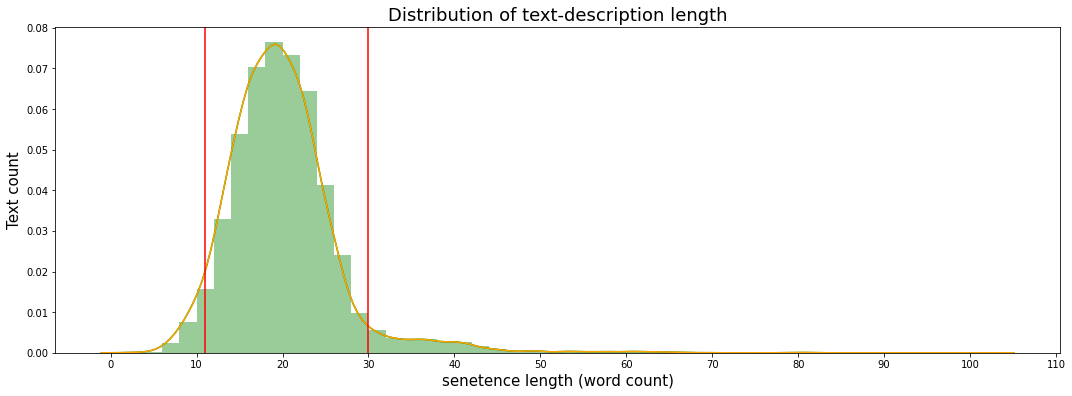

In [16]:
plt.figure(figsize=(18,6))

plot_data = [len(cnt) for cnt in df_text['lemmatized_description']]
sns.distplot(plot_data, color='green')
sns.kdeplot(plot_data, color='orange')

plt.axvline(np.quantile(plot_data, 0.95), color='r')
plt.axvline(np.quantile(plot_data, 0.05), color='r')

plt.yticks()
plt.xticks(list(range(0, 120, 10)))
plt.xlabel('senetence length (word count)', fontsize=15)
plt.ylabel('Text count', fontsize=15)
plt.title('Distribution of text-description length', fontsize=18)
plt.show();

- 90% of the descriptions are within length of 10 to 30
- We may need to drop documents outside this range

#### descriptions which are too small:

In [17]:
print(len(df_text.loc[df_text['lemmatized_description'].str.len()<7]))
df_text.loc[df_text['lemmatized_description'].str.len()<7].head(3)

19


,description,cleaned_description,tokenized_description,lemmatized_description,lemmatized_description2
41,&lt;strong&gt;Analysis&lt;/strong&gt; Standardised phones? Pah!,strong analysis strong standardised phones pah,"[strong, analysis, strong, standardised, phones, pah]","[strong, analysis, strong, standardised, phone, pah]","[strong, analysis, strong, standardised, phone, pah]"
583,"Shipments go up, prices go down...with more of the same on the horizon.",shipments go up prices go down with more of the same on the horizon,"[shipments, go, prices, go, horizon]","[shipment, go, price, go, horizon]","[shipment, price, horizon]"
866,Companies are teaming up to bring their technology to your living room.,companies are teaming up to bring their technology to your living room,"[companies, teaming, bring, technology, living, room]","[company, team, bring, technology, living, room]","[company, team, bring, technology, living, room]"


#### Descriptions which are too big:

In [18]:
print(len(df_text.loc[df_text['lemmatized_description'].str.len()>40]))
df_text.loc[df_text['lemmatized_description'].str.len()>40].head(3)

147


,description,cleaned_description,tokenized_description,lemmatized_description,lemmatized_description2
4,The U.S. Supreme Court has agreed to review an appeals court ruling that opens up cable networks to competing Internet service providers (ISPs).&lt;p&gt;ADVERTISEMENT&lt;/p&gt;&lt;p&gt;&lt;img src...,the unitedstate supreme court has agreed to review an appeals court ruling that opens up cable networks to competing internet service providers p advertisement p p img src http ad doublecli...,"[unitedstate, supreme, court, agreed, review, appeals, court, ruling, opens, cable, networks, competing, internet, service, providers, p, advertisement, p, p, img, src, http, ad, doubleclick, net,...","[unitedstate, supreme, court, agree, review, appeal, court, ruling, open, cable, network, compete, internet, service, provider, p, advertisement, p, p, img, src, http, ad, doubleclick, net, ad, id...","[unitedstate, supreme, court, agree, review, appeal, court, ruling, open, cable, network, compete, internet, service, provider, advertisement, src, http, doubleclick, net, idg, ifw, general, solar..."
20,A security advisory posted on Bugtraq demonstrates how hackers can compromise customers of T-mobile wireless and Verizon (landline) voicemail boxes. The advisory talks about the use of Caller-ID s...,a security advisory posted on bugtraq demonstrates how hackers can compromise customers of t mobile wireless and verizon voicemail boxes the advisory talks about the use of caller id spoofing th...,"[security, advisory, posted, bugtraq, demonstrates, hackers, compromise, customers, mobile, wireless, verizon, voicemail, boxes, advisory, talks, use, caller, id, spoofing, customers, number, allo...","[security, advisory, post, bugtraq, demonstrate, hacker, compromise, customer, mobile, wireless, verizon, voicemail, box, advisory, talk, use, caller, i, d, spoof, customer, number, allow, bypass,...","[security, advisory, post, bugtraq, demonstrate, hacker, compromise, customer, mobile, wireless, verizon, voicemail, box, advisory, talk, use, caller, spoof, customer, number, allow, bypass, pin, ..."
38,"NEW YORK (Reuters) - Sprint Corp. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=FON.N target=/stocks/quickinfo/fullquote""&gt;FON.N&lt;/A&gt; on Wednesday agreed to buy mobile...",new york sprint corp a href http www investor reuters com fullquote aspx ticker fon n target stocks quickinfo fullquote fon n a on wednesday agreed to buy mobile telephone company nexte...,"[new, york, sprint, corp, href, http, www, investor, reuters, com, fullquote, aspx, ticker, fon, n, target, stocks, quickinfo, fullquote, fon, n, wednesday, agreed, buy, mobile, telephone, company...","[new, york, sprint, corp, href, http, www, investor, reuter, com, fullquote, aspx, ticker, fon, n, target, stock, quickinfo, fullquote, fon, n, wednesday, agree, buy, mobile, telephone, company, n...","[new, york, sprint, corp, href, http, www, investor, reuter, com, fullquote, aspx, ticker, fon, target, stock, quickinfo, fullquote, fon, wednesday, agree, buy, mobile, telephone, company, nextel,..."


#### From above analysis:
- Some of the descriptons are short and while some are long, which is expected behaviour of normally distributed data
- Since we are dealing with unlabled data dropping this record wont provide any statistical benifits

### Saving cleaned file.

In [19]:
# df_text['lemmatized_description'].to_csv('cleaned_data.csv')
df_text[['cleaned_description','lemmatized_description']].to_csv('cleaned_data.csv')

### Get word frequency:
- I am using nltk fdist to get a frequency distribution of all words

In [20]:
all_words = [word for item in list(df_text['lemmatized_description']) for word in item]

fdist = FreqDist(all_words)
len(fdist)

17244

#### choose k and visually inspect the top 10 words of the top k
- We have 17244 words

In [21]:
k = 10000
top_k_words = fdist.most_common(k)
top_k_words[:10]

[('say', 2126),
 ('new', 1446),
 ('year', 1093),
 ('company', 776),
 ('we', 749),
 ('two', 720),
 ('first', 716),
 ('quot', 691),
 ('wednesday', 670),
 ('ap', 657)]

In [22]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [23]:
df_text['topk_description'] = df_text['lemmatized_description'].apply(keep_top_k_words)
df_text[df_text.columns[-3:]].tail(3)

,lemmatized_description,lemmatized_description2,topk_description
9997,"[reuter, ahman, green, score, three, touchdown, rush, yard, green, bay, packer, open, season, convincing, win, carolina, panther, charlotte, monday]","[reuter, ahman, green, score, touchdown, rush, yard, green, bay, packer, open, season, convincing, win, carolina, panther, charlotte, monday]","[reuter, ahman, green, score, three, touchdown, rush, yard, green, bay, packer, open, season, convincing, win, carolina, panther, charlotte, monday]"
9998,"[nebraska, capitalize, four, pittsburgh, turnover, bat, pass, end, zone, game, final, play, yesterday, preserve, win, first, meeting, team, since]","[nebraska, capitalize, pittsburgh, turnover, bat, pass, end, zone, game, final, play, yesterday, preserve, win, meeting, team]","[nebraska, capitalize, four, pittsburgh, turnover, bat, pass, end, zone, game, final, play, yesterday, preserve, win, first, meeting, team, since]"
9999,"[new, york, pepsico, inc, href, http, www, investor, reuter, com, fullquote, aspx, ticker, pep, n, target, stock, quickinfo, fullquote, pep, n, world, soft, drink, company, say, thursday, quarterl...","[new, york, pepsico, inc, href, http, www, investor, reuter, com, fullquote, aspx, ticker, pep, target, stock, quickinfo, fullquote, pep, world, soft, drink, company, say, thursday, quarterly, pro...","[new, york, pepsico, inc, href, http, www, investor, reuter, com, fullquote, aspx, ticker, pep, n, target, stock, quickinfo, fullquote, pep, n, world, soft, drink, company, say, thursday, quarterl..."


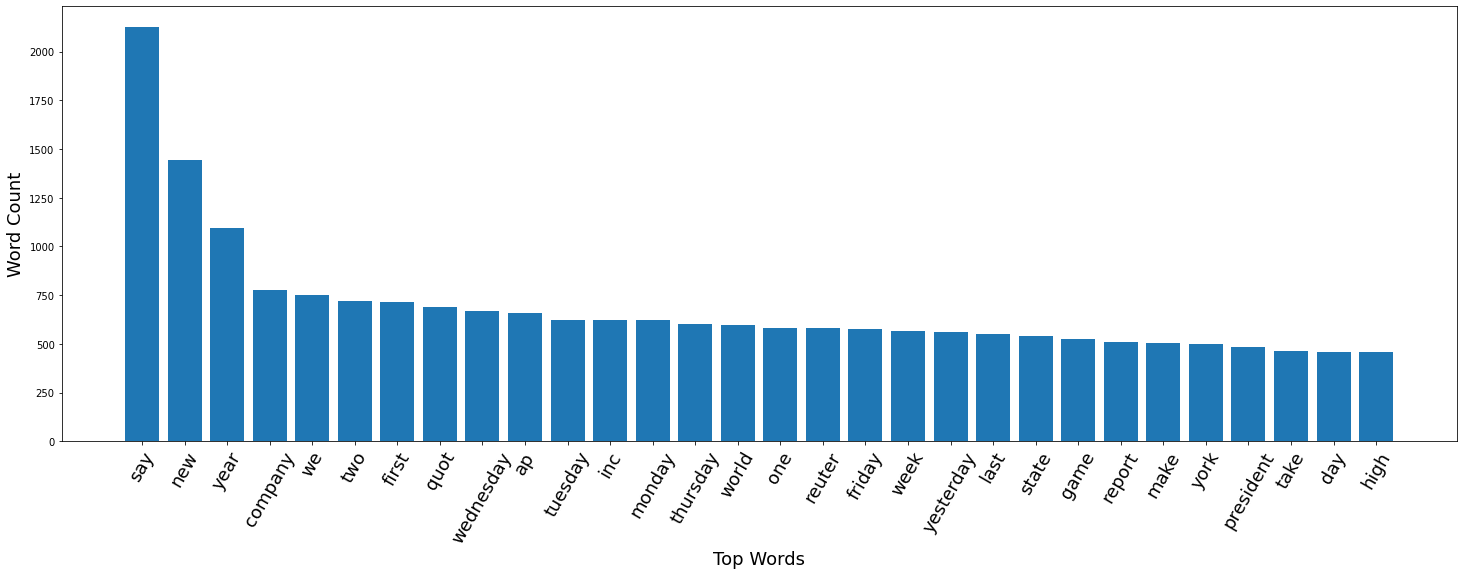

In [24]:
word_dict = {}
for senetence in df_text['lemmatized_description']:
    for word in senetence:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1
                      
word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse=True))
word_dict2 = dict(itertools.islice(word_dict.items(), 30))  

plt.figure(figsize=(25,8))
plt.bar(range(len(word_dict2)), word_dict2.values(), align='center')
plt.xlabel('Top Words', fontsize = 18)
plt.ylabel('Word Count', fontsize = 18)
plt.xticks(range(len(word_dict2)), list(word_dict2.keys()))
plt.xticks(rotation=60, fontsize = 18)
plt.show()

#### Wordcloud

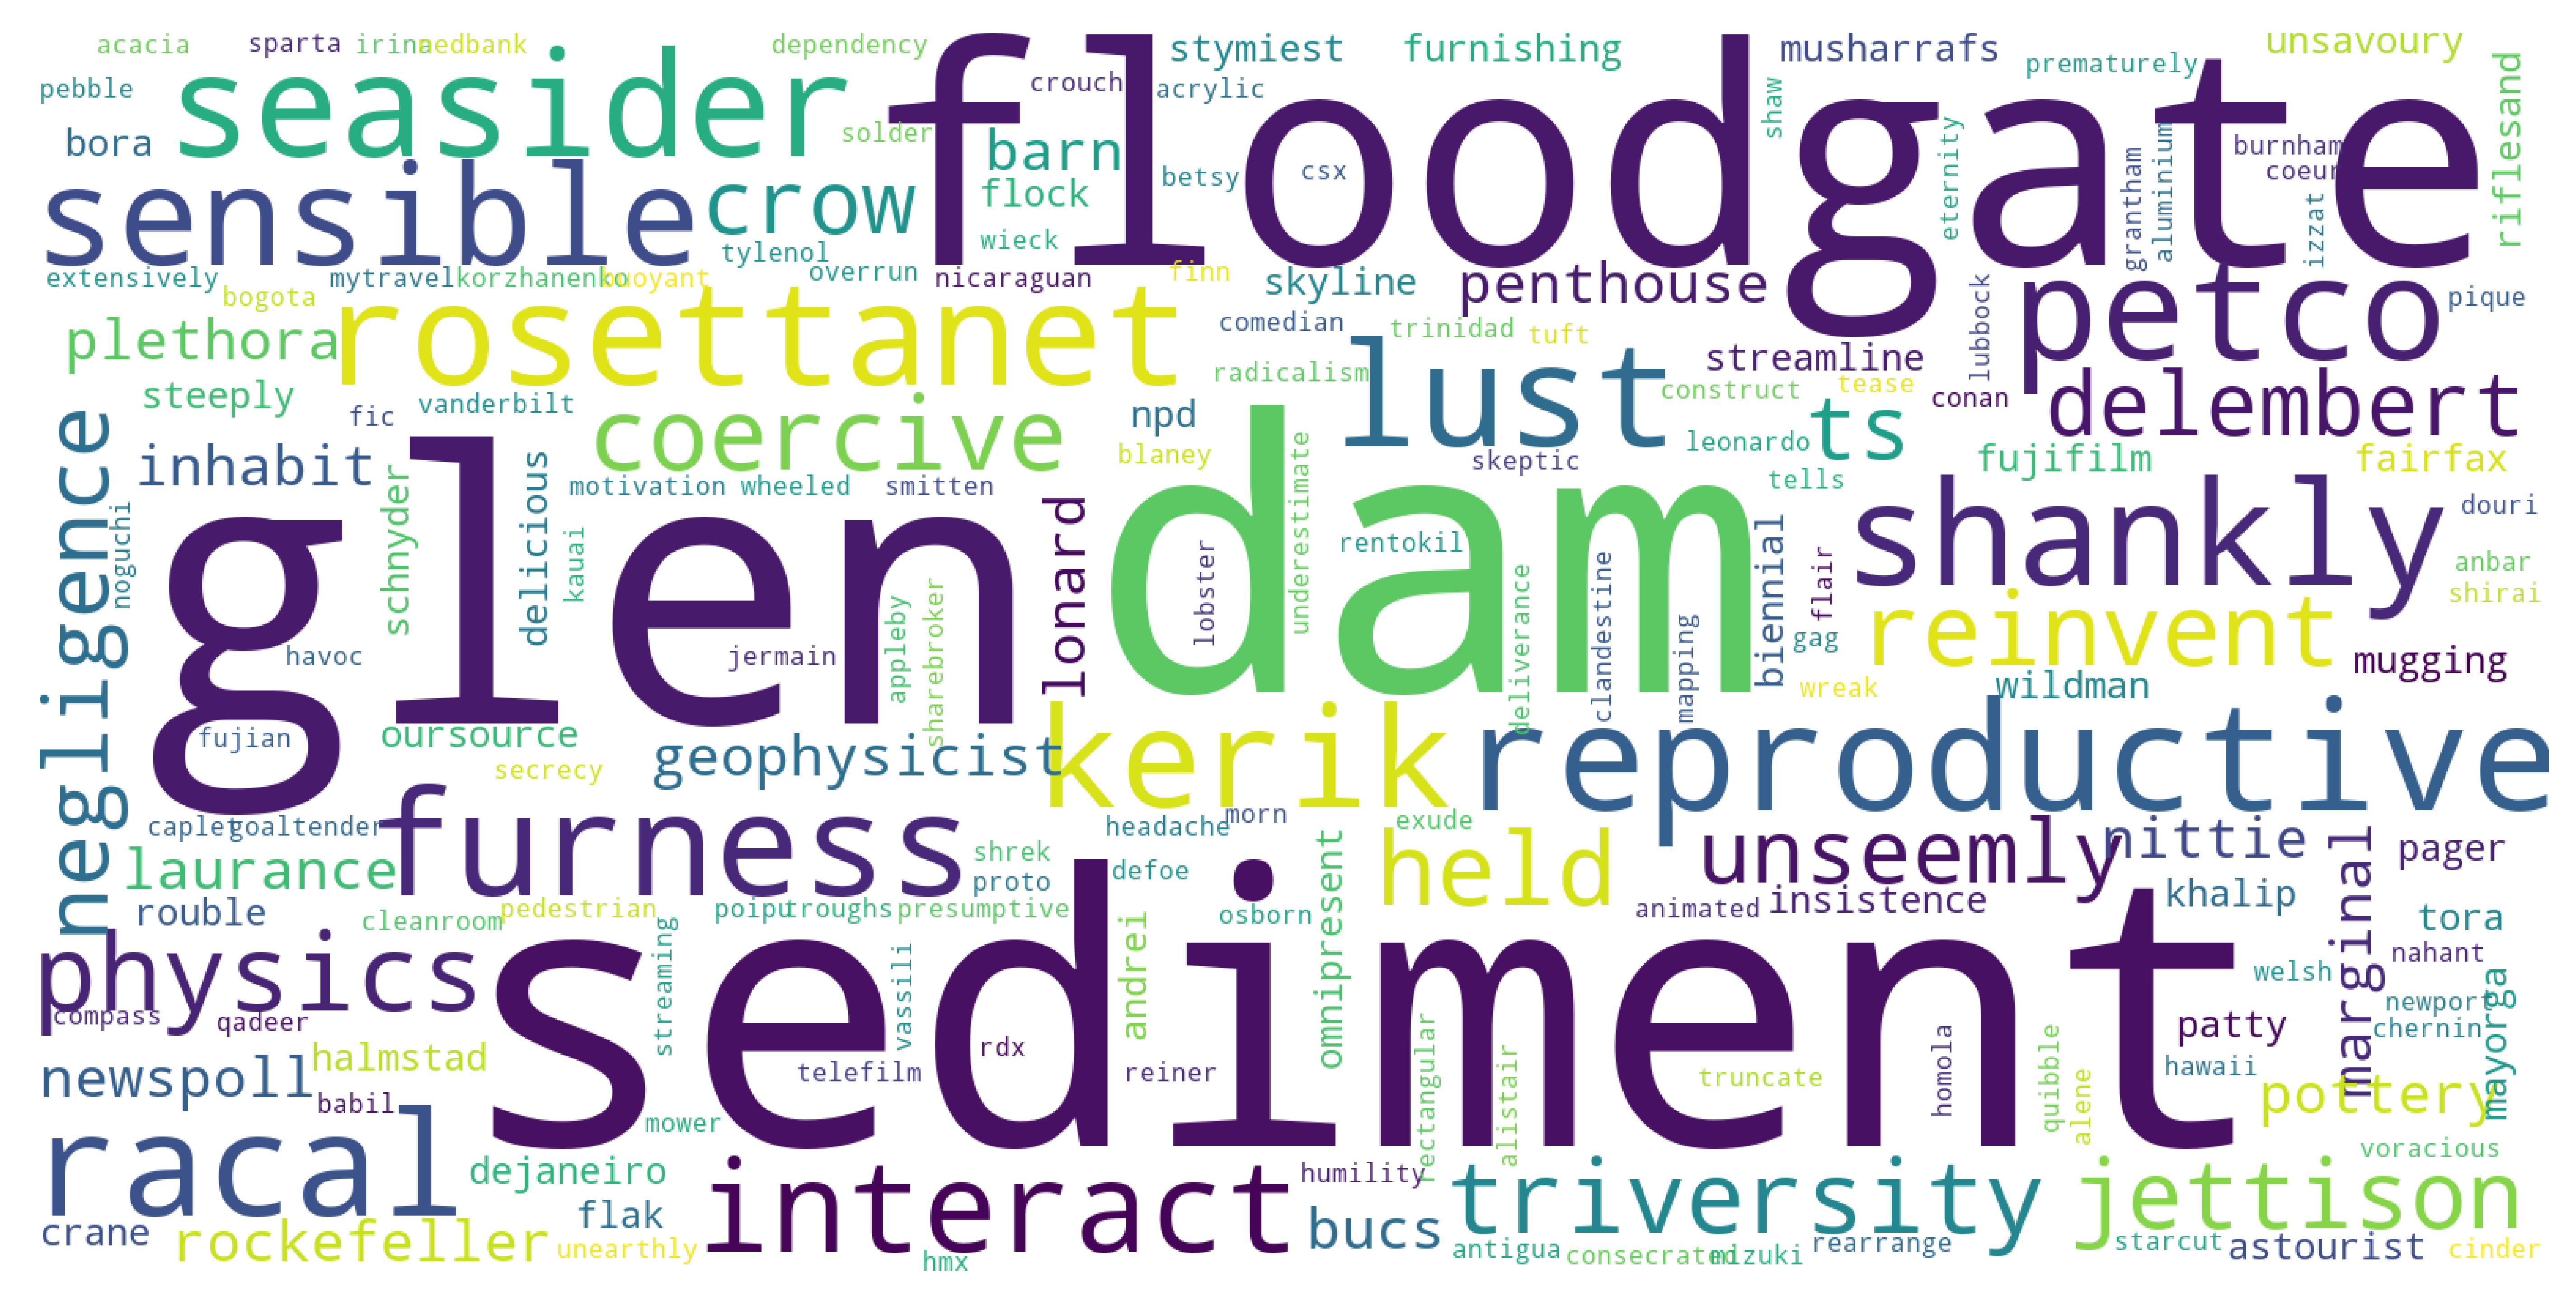

In [25]:
newdict = {val:key for key, val in enumerate(word_dict) if not val in stop_words}  
wordcloud2 = WordCloud(background_color='white', scale=4, margin = 2, max_font_size = 60).generate_from_frequencies(newdict)
fig = plt.figure(figsize=(12,8), dpi= 600, facecolor='w', edgecolor='k')
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

## Things to try:
### 1. Coreference resolution:
> the coreference resolution tries to find all expressions in the text that refer to a specific entity.

## Conclusion:
- Data Cleaning is ensential part of any Machine learning task
- We were able to clean data using NLTK, Spacy library
- Data cleaning is iterative process, we can improve on data cleaning as we get more insight and response from our models